In [255]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [338]:
with open('part-r-00000.txt', 'r') as f:
    lines = f.readlines()

data = []
for line in lines:
    customer_id, values = line.strip().split('\t')
    vals = values.split(',')
    data.append([float(customer_id)] + [float(v) for v in vals])

# Tạo dataframe
df = pd.DataFrame(data, columns=['CustomerID', 'TotalTransactions', 'TotalProductsPurchased', 'TotalSpend', 'AvgTransactionValue'])

print(df.head())

   CustomerID  TotalTransactions  TotalProductsPurchased  TotalSpend  \
0     12346.0                2.0                     0.0        0.00   
1     12347.0                7.0                  2446.0     4299.80   
2     12348.0                4.0                  2332.0     1437.24   
3     12349.0                1.0                   630.0     1457.55   
4     12350.0                1.0                   196.0      294.40   

   AvgTransactionValue  
0             0.000000  
1           614.257143  
2           359.310000  
3          1457.550000  
4           294.400000  


In [339]:
# 1. Thay giá trị âm bằng 0
for col in ['TotalSpend', 'TotalProductsPurchased', 'AvgTransactionValue']:
    df[col] = df[col].apply(lambda x: x if x >= 0 else 0)

In [340]:
# Danh sách đặc trưng
features = ['TotalTransactions', 'TotalProductsPurchased', 'TotalSpend', 'AvgTransactionValue']
data_for_clustering = df[features]

In [341]:
# 2. Biến đổi Yeo-Johnson để giảm skewness
pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(data_for_clustering)
transformed_df = pd.DataFrame(transformed_data, columns=features)

In [342]:
# Kiểm tra skewness sau Yeo-Johnson
print("Skewness:")
print(transformed_df.skew())

Skewness:
TotalTransactions         0.185850
TotalProductsPurchased    0.051082
TotalSpend                0.080885
AvgTransactionValue       0.271636
dtype: float64


In [343]:
# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(transformed_data)

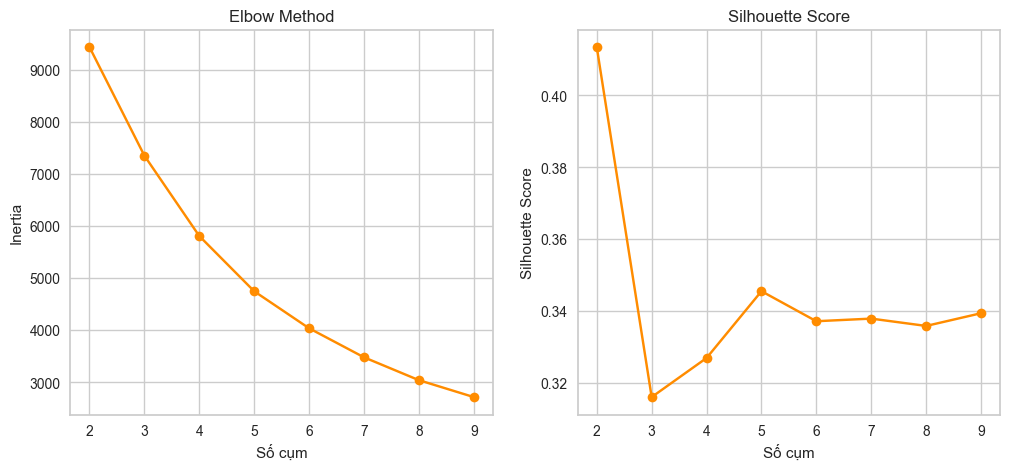

In [344]:
# K-means: Tìm số cụm tối ưu
inertias = []
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Vẽ Elbow Curve và Silhouette Score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Số cụm')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Số cụm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [359]:
print("Silhouette Score:", silhouette_score(scaled_data, df['Cluster']))

Silhouette Score: 0.32697373187011464


In [345]:
# 5. Chạy K-means với 4 cụm
kmeans = KMeans(n_clusters=4, n_init=50, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

In [346]:
# 6. Phân tích cụm
# Tỷ lệ khách hàng trong mỗi cụm
print("Tỷ lệ khách hàng trong mỗi cụm:")
print(df['Cluster'].value_counts(normalize=True))

Tỷ lệ khách hàng trong mỗi cụm:
Cluster
0    0.313761
2    0.266284
1    0.245183
3    0.174771
Name: proportion, dtype: float64


In [358]:
# Kiểm tra số lượng phần tử trong mỗi cụm
pd.Series(df['Cluster'] ).value_counts()

Cluster
0    1368
2    1161
1    1069
3     762
Name: count, dtype: int64

Trực quan bằng biểu đồ

C:\Users\Admin\AppData\Local\Temp\ipykernel_9204\2976028262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_percent, palette='Set2')


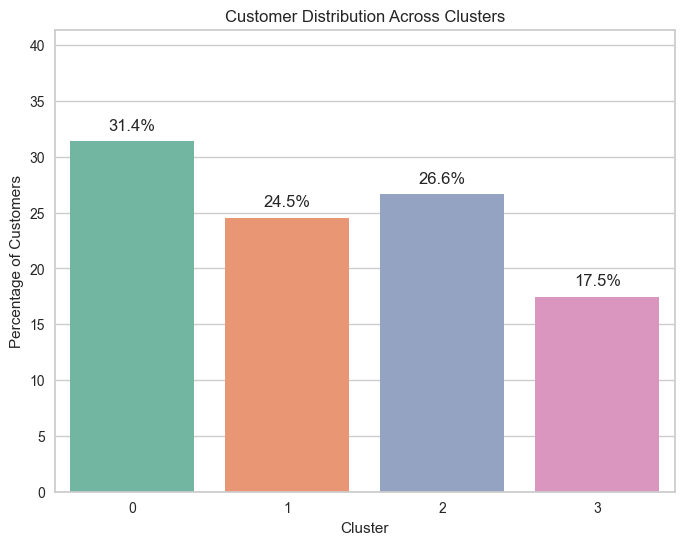

In [348]:
# Đếm số lượng khách hàng trong mỗi cụm
cluster_counts = df['Cluster'].value_counts().sort_index()

# Tính tỷ lệ %
cluster_percent = (cluster_counts / cluster_counts.sum()) * 100

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=cluster_counts.index, y=cluster_percent, palette='Set2')

for i, v in enumerate(cluster_percent):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.xlabel('Cluster')
plt.ylabel('Percentage of Customers')
plt.title('Customer Distribution Across Clusters')
plt.ylim(0, cluster_percent.max() + 10)

plt.show()

In [347]:
# Giá trị trung bình của các đặc trưng theo cụm
print("\nGiá trị trung bình của các đặc trưng theo cụm:")
cluster_means = df.groupby('Cluster')[features].mean()
print(cluster_means)


Giá trị trung bình của các đặc trưng theo cụm:
         TotalTransactions  TotalProductsPurchased   TotalSpend  \
Cluster                                                           
0                 5.603070              684.728070  1146.025892   
1                 1.545370               96.342376   170.954097   
2                 1.415159              351.543497   568.831352   
3                14.166667             4448.379265  7636.747690   

         AvgTransactionValue  
Cluster                       
0                 222.526772  
1                 120.184678  
2                 423.827801  
3                 619.738282  


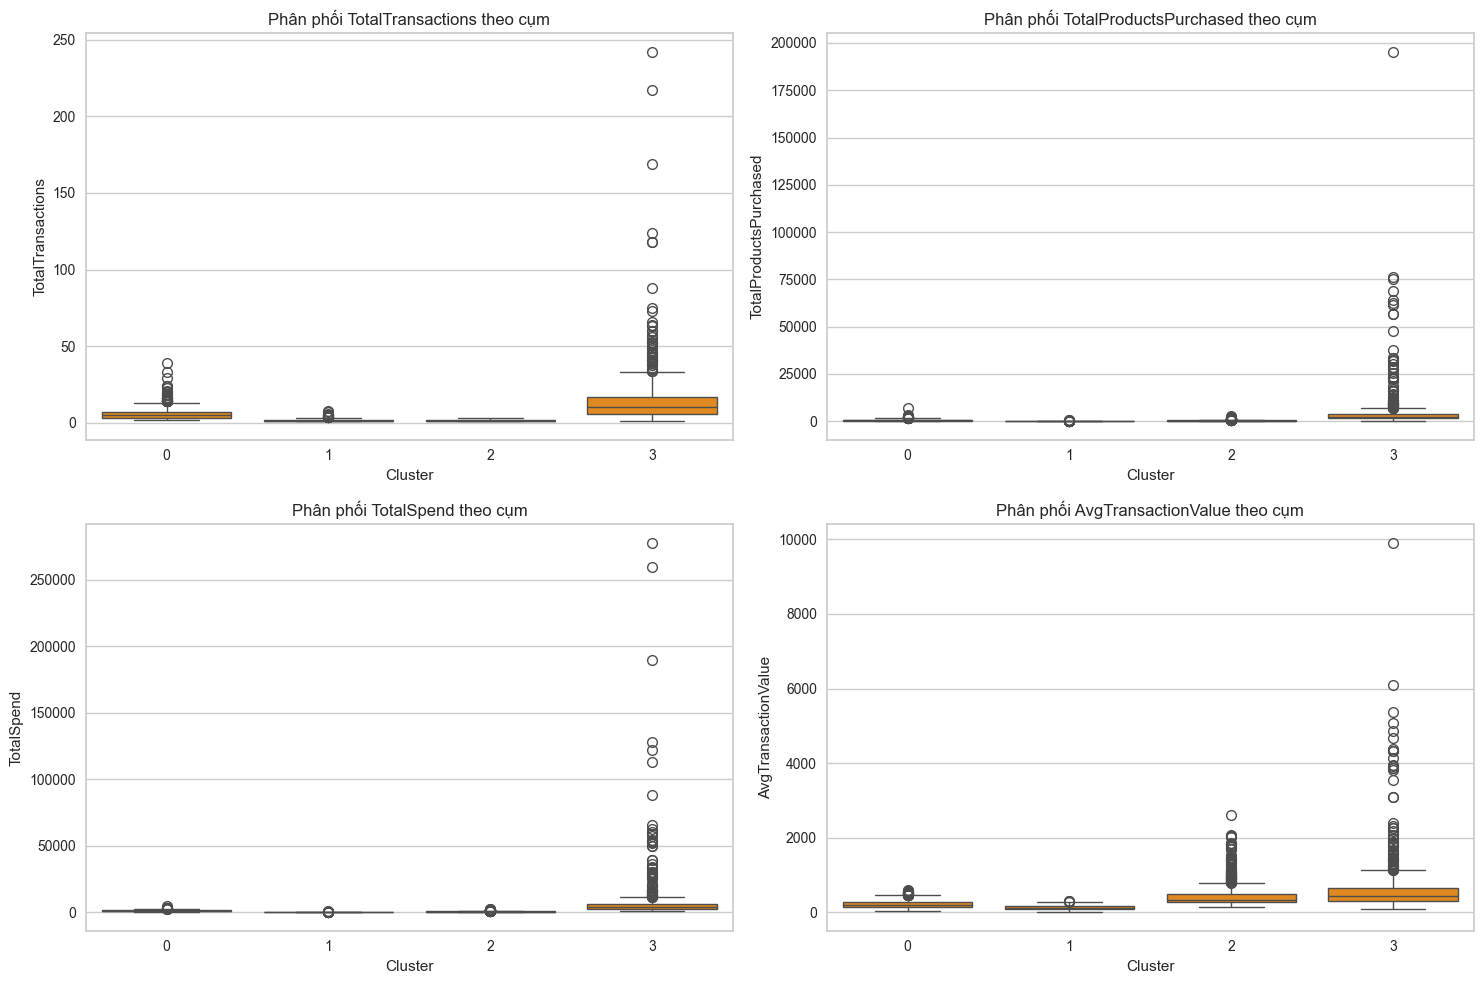

In [349]:
# 7. Trực quan hóa phân phối đặc trưng theo cụm
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'Phân phối {feature} theo cụm')
plt.tight_layout()
plt.show()

In [352]:
# 8. Gán nhãn cụm
# Tính trung bình tổng thể (trọng số theo tỷ lệ cụm)

print("Trung bình tổng thể của các đặc trưng:")
print(df[features].mean())

Trung bình tổng thể của các đặc trưng:
TotalTransactions            4.989679
TotalProductsPurchased    1109.519495
TotalSpend                1887.644103
AvgTransactionValue        320.458416
dtype: float64


## Phân tích từng cụm

Dựa trên giá trị trung bình của các cụm và so sánh với trung bình tổng thể, phân tích hành vi mua sắm:

### Cụm 0 (31.38%):

- **TotalTransactions**: 5.60 (~trung bình tổng thể, 5.31).
- **TotalProductsPurchased**: 684.73 (thấp hơn trung bình, 1037.62).
- **TotalSpend**: 1146.03 (thấp hơn trung bình, 1837.53).
- **AvgTransactionValue**: 222.53 (thấp hơn trung bình, 324.13).

**Hành vi**:  
Khách hàng có số giao dịch trung bình, nhưng mua ít sản phẩm và chi tiêu thấp mỗi giao dịch. Đây là nhóm **khách thông thường**, mua sắm đều đặn nhưng không chi tiêu nhiều.

---

### Cụm 1 (24.52%):

- **TotalTransactions**: 1.55 (rất thấp, so với 5.31).
- **TotalProductsPurchased**: 96.34 (rất thấp, so với 1037.62).
- **TotalSpend**: 170.95 (rất thấp, so với 1837.53).
- **AvgTransactionValue**: 120.18 (rất thấp, so với 324.13).

**Hành vi**:  
Khách hàng ít giao dịch, mua ít sản phẩm, chi tiêu thấp, và giá trị giao dịch trung bình thấp. Đây là nhóm **khách không hoạt động**, có mức độ tương tác rất thấp.

---

### Cụm 2 (26.63%):

- **TotalTransactions**: 1.42 (rất thấp, so với 5.31).
- **TotalProductsPurchased**: 351.54 (thấp hơn trung bình, 1037.62).
- **TotalSpend**: 568.83 (thấp hơn trung bình, 1837.53).
- **AvgTransactionValue**: 423.83 (cao hơn trung bình, 324.13).

**Hành vi**:  
Khách hàng giao dịch rất ít, mua ít sản phẩm, nhưng mỗi giao dịch có giá trị cao. Đây là nhóm **khách mua ít nhưng giá trị cao**, có xu hướng mua các sản phẩm đắt tiền trong ít lần giao dịch.

---

### Cụm 3 (17.48%):

- **TotalTransactions**: 14.17 (cao hơn nhiều, so với 5.31).
- **TotalProductsPurchased**: 4448.38 (cao hơn nhiều, so với 1037.62).
- **TotalSpend**: 7636.75 (cao hơn nhiều, so với 1837.53).
- **AvgTransactionValue**: 619.74 (cao hơn nhiều, so với 324.13).

**Hành vi**:  
Khách hàng giao dịch nhiều, mua rất nhiều sản phẩm, chi tiêu lớn, và mỗi giao dịch có giá trị cao. Đây là nhóm **khách VIP**, có mức độ mua sắm tích cực nhất.

---

## Gán nhãn cho các cụm

Dựa trên phân tích trên, gán nhãn cho các cụm như sau:

| Cụm | Tỷ lệ   | Nhãn                         | Mô tả hành vi mua sắm                                          |
|:----|:--------|:-----------------------------|:---------------------------------------------------------------|
| 0    | 31.38%  | Khách thông thường           | Giao dịch trung bình, mua ít sản phẩm, chi tiêu thấp, giá trị giao dịch trung bình. |
| 1    | 24.52%  | Khách không hoạt động        | Ít giao dịch, mua ít sản phẩm, chi tiêu thấp, giá trị giao dịch thấp. |
| 2    | 26.63%  | Khách mua ít nhưng giá trị cao | Ít giao dịch, mua ít sản phẩm, nhưng chi tiêu cao mỗi giao dịch. |
| 3    | 17.48%  | Khách VIP                    | Giao dịch nhiều, mua nhiều sản phẩm, chi tiêu lớn, giá trị giao dịch cao. |


### Gán nhãn và kiểm tra

In [362]:
cluster_labels = {
    0: 'Khách thông thường',
    1: 'Khách không hoạt động',
    2: 'Khách mua ít nhưng giá trị cao',
    3: 'Khách VIP'
}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)
print(df['Cluster_Label'].value_counts(normalize=True))

Cluster_Label
Khách thông thường                0.313761
Khách mua ít nhưng giá trị cao    0.266284
Khách không hoạt động             0.245183
Khách VIP                         0.174771
Name: proportion, dtype: float64


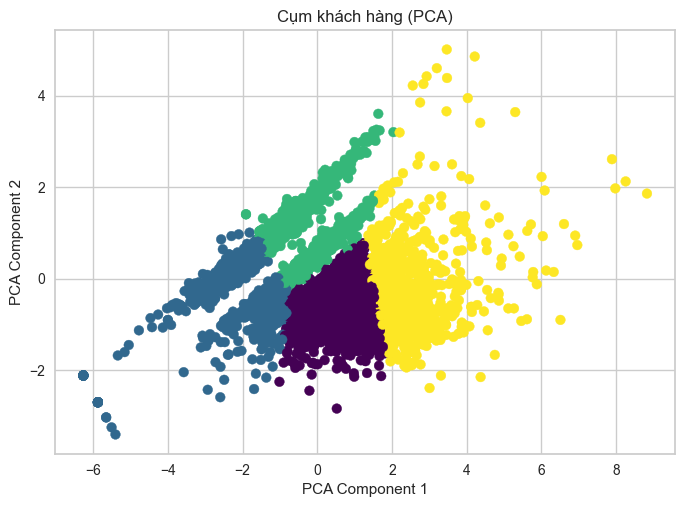

In [356]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cụm khách hàng (PCA)')
plt.show()

### Lưu kết quả 

In [363]:

df.to_csv('clustered_customers_done.csv', index=False)
print("\nĐã lưu kết quả vào 'clustered_customers.csv'")


Đã lưu kết quả vào 'clustered_customers.csv'
